In [87]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

In [88]:
data_root = "recordings"
csv_files = glob.glob(os.path.join(data_root, "**", "rt60_data_new_*.csv"), recursive=True)
csv_files

['recordings\\ ZW10-2-3\\20250509_101714\\rt60_data_new_20250509_101714.csv',
 'recordings\\HO2-75\\20250506_135353\\rt60_data_new_20250506_135353.csv',
 'recordings\\HO2-76\\20250506_133732\\rt60_data_new_20250506_133732.csv',
 'recordings\\HO2-80\\20250506_134619\\rt60_data_new_20250506_134619.csv',
 'recordings\\HO2-85\\20250506_141605\\rt60_data_new_20250506_141605.csv',
 'recordings\\HO2-86\\20250506_135953\\rt60_data_new_20250506_135953.csv',
 'recordings\\HO2-88\\20250506_140327\\rt60_data_new_20250506_140327.csv',
 'recordings\\HO2-90\\20250506_135906\\rt60_data_new_20250506_135906.csv',
 'recordings\\HO2-91\\20250506_140442\\rt60_data_new_20250506_140442.csv',
 'recordings\\HO2-92\\20250506_141807\\rt60_data_new_20250506_141807.csv',
 'recordings\\HO2-93\\20250506_135239\\rt60_data_new_20250506_135239.csv',
 'recordings\\HO2-95\\20250506_133108\\rt60_data_new_20250506_133108.csv',
 'recordings\\ZN10-1\\20250509_104608\\rt60_data_new_20250509_104608.csv',
 'recordings\\ZN10-10\

In [89]:
room_data = []
for csv_file in csv_files:
    room_name = os.path.split(csv_file)[0].split(os.sep)[-2]
    df = pd.read_csv(csv_file)
    df["Room"] = room_name
    room_data.append(df)

data = pd.concat(room_data, ignore_index=True)
data = data[data["Frequency (Hz)"] >= 100]
data.head(10)

,Frequency (Hz),RT60 (s),Room
3,100,1.559530,ZW10-2-3
4,125,1.320793,ZW10-2-3
5,250,1.268846,ZW10-2-3
6,500,0.851036,ZW10-2-3
7,1000,0.550213,ZW10-2-3
8,2000,0.442399,ZW10-2-3
9,4000,24.577746,ZW10-2-3
10,8000,0.447799,ZW10-2-3
11,12000,0.336744,ZW10-2-3
12,16000,0.282816,ZW10-2-3


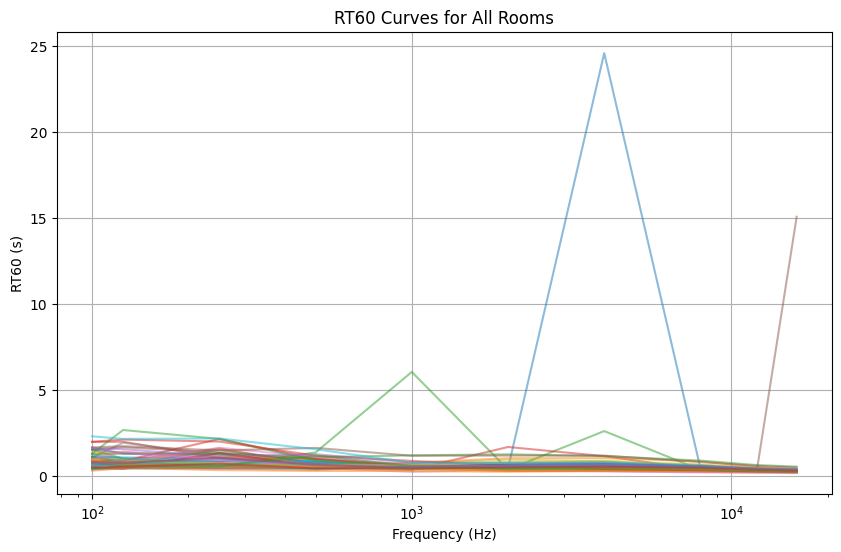

In [90]:
plt.figure(figsize=(10, 6))
for room, group in data.groupby("Room"):
    plt.plot(group["Frequency (Hz)"], group["RT60 (s)"], alpha=0.5, label=room)

plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("RT60 (s)")
plt.title("RT60 Curves for All Rooms")
plt.grid(True)
plt.show()

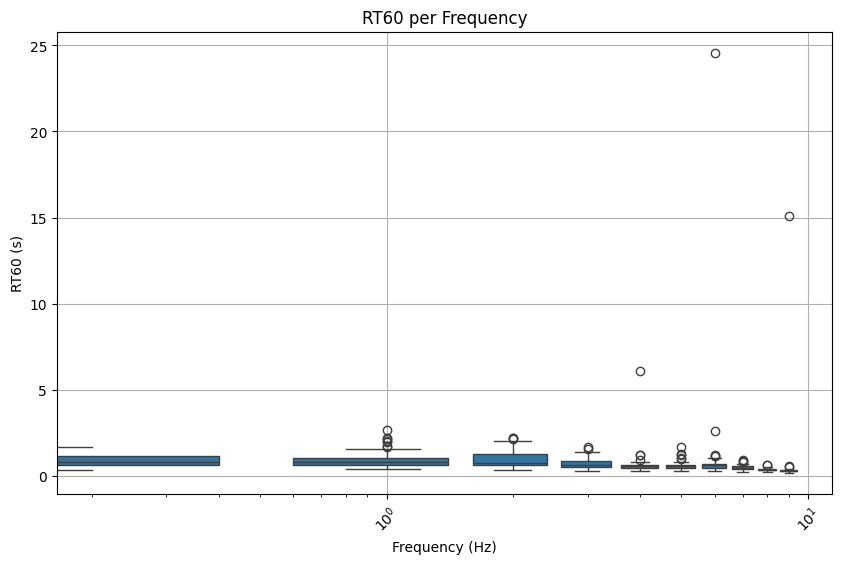

In [91]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x="Frequency (Hz)", y="RT60 (s)", data=data)
plt.xscale("log")
plt.xticks(rotation=45)
plt.title("RT60 per Frequency")
plt.grid(True)
plt.show()

C:\Users\Leo\AppData\Local\Temp\ipykernel_29364\2472099893.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_z = data.groupby("Frequency (Hz)", group_keys=False).apply(mark_outliers)


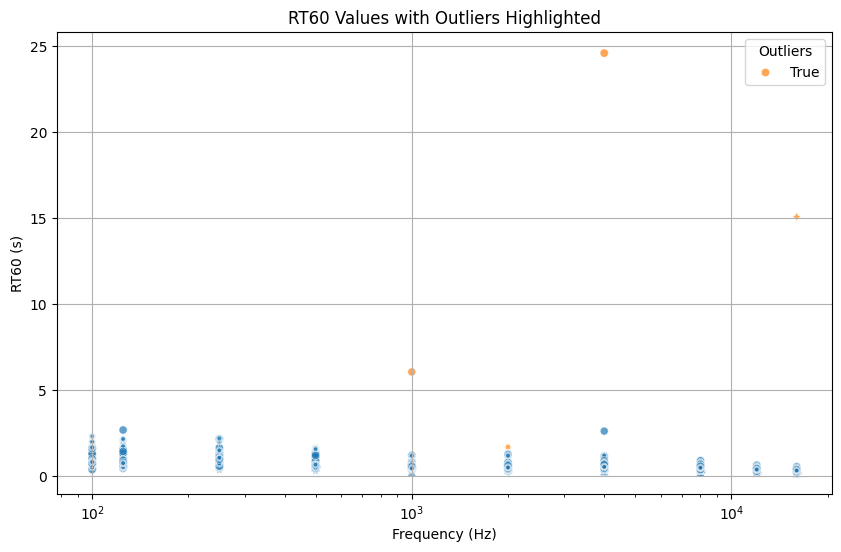

🔍 Found 4 outlier points across 4 rooms.


In [92]:
from scipy.stats import zscore

# Compute z-scores per frequency band
def mark_outliers(df):
    df["Z"] = zscore(df["RT60 (s)"])
    df["Outlier"] = df["Z"].abs() > 4
    return df

data_z = data.groupby("Frequency (Hz)", group_keys=False).apply(mark_outliers)

# Plot outliers
outliers = data_z[data_z["Outlier"]]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_z, x="Frequency (Hz)", y="RT60 (s)", hue="Outlier", style="Room", alpha=0.7)
plt.xscale("log")
plt.title("RT60 Values with Outliers Highlighted")
plt.grid(True)
#only show legend for outliers
handles, labels = plt.gca().get_legend_handles_labels()
outlier_handles = [handles[i] for i in range(len(labels)) if labels[i] == "True"]
outlier_labels = [labels[i] for i in range(len(labels)) if labels[i] == "True"]
plt.legend(outlier_handles, outlier_labels, title="Outliers", loc="upper right")

plt.show()

print(f"🔍 Found {len(outliers)} outlier points across {outliers['Room'].nunique()} rooms.")


In [93]:
outlier_summary = outliers.groupby("Room").size().reset_index(name="Outlier Count")
print(outlier_summary.sort_values("Outlier Count", ascending=False))


        Room  Outlier Count
0   ZW10-2-3              1
1     HO2-86              1
2      ZO9-1              1
3     ZO9-12              1


In [94]:
# all rooms with times over 4 seconds
outliers_over_4s = data[data["RT60 (s)"] > 4]
print(f"🔍 Found {len(outliers_over_4s)} outlier points across {outliers_over_4s['Room'].nunique()} rooms."
      f" {outliers_over_4s["RT60 (s)"].max()}s max RT60.")
outliers_over_4s_summary = outliers_over_4s.groupby("Room").size().reset_index(name="Outlier Count")
print(outliers_over_4s_summary.sort_values("Outlier Count", ascending=False))


🔍 Found 3 outlier points across 3 rooms. 24.57774603808292s max RT60.
        Room  Outlier Count
0   ZW10-2-3              1
1     HO2-86              1
2      ZO9-1              1


In [95]:
# print data of outliers
for room, group in outliers_over_4s.groupby("Room"):
    print(f"Room: {room}")
    print(group[["Frequency (Hz)", "RT60 (s)"]])
    print()

Room:  ZW10-2-3
   Frequency (Hz)   RT60 (s)
9            4000  24.577746

Room: HO2-86
    Frequency (Hz)   RT60 (s)
77           16000  15.070548

Room: ZO9-1
     Frequency (Hz)  RT60 (s)
293            1000  6.055387

